### Machine Learning

### Feature Engineering

This phase will transform our features to provide our model with data in a more digestible form. Skewed numericals will have to be normalized, high cardinality categorical features will need to be grouped and some numeric columns will need to be binned. Since our initial model will be using a distance based algorithm, it is important to normalize highly skewed features to lessen the influence of extreme values. To avoid overfitting we must group our high cardinality features and for extremely skewed features we use binning as an alternative to transforming. Our subsequent models will process faster, be less prone to overfitting and will better understand influences that determine cancellations.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import os

In [54]:
# Read in clean data
hotels = pd.read_csv('data/hotels_clean.csv', index_col=0)

In [55]:
# Map months of the year to numeric values to create arrival date column for exploration
d = {'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12, 'January':1, 'February':2, 'March':3, 'April':4, 'May': 5, 'June':6}
hotels.arrival_date_month = hotels.arrival_date_month.map(d)

In [56]:
hotels.info() ### What happened to the kids column??

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119386 entries, 0 to 119389
Data columns (total 33 columns):
hotel                             119386 non-null object
is_canceled                       119386 non-null int64
lead_time                         119386 non-null int64
arrival_date_year                 119386 non-null int64
arrival_date_month                119386 non-null int64
arrival_date_week_number          119386 non-null int64
arrival_date_day_of_month         119386 non-null int64
stays_in_weekend_nights           119386 non-null int64
stays_in_week_nights              119386 non-null int64
adults                            119386 non-null int64
children                          119386 non-null int64
babies                            119386 non-null int64
meal                              119386 non-null object
country                           119386 non-null object
market_segment                    119386 non-null object
distribution_channel              119386 non-

In [57]:
# read in results dataframes from statistical analysis
chi_square_results = pd.read_csv('data/chi_square_results.csv', index_col=0)
t_stat_results = pd.read_csv('data/t_stat_results.csv', index_col=0)

In [58]:
# Use results from statistical analysis to form features list
cat_features = chi_square_results.index.to_list()
num_features = t_stat_results[t_stat_results['result'] != 'Ind (fail to reject H0)'].index.to_list()
features = cat_features + num_features

In [59]:
# Add label to features to be removed later on when the data is split
features.append('is_canceled')

### Selected features from statistical analysis phase

In [60]:
# dataframe for feature engineering
data = hotels[features]

In [61]:
data.describe(include='O').T

count unique         top    freq
hotel                 119386      2  City Hotel   79326
country               119386    178         PRT   48587
market_segment        119386      7   Online TA   56476
distribution_channel  119386      5       TA/TO   97869
reserved_room_type    119386     10           A   85993
customer_type         119386      4   Transient   89612
kids                  119386      2     no_kids  110056

In [62]:
data.describe(exclude='O').T

count         mean         std     min  \
lead_time                       119386.0   104.014474  106.863548     0.0   
arrival_date_year               119386.0  2016.156585    0.707464  2015.0   
arrival_date_month              119386.0     6.552477    3.090607     1.0   
arrival_date_week_number        119386.0    27.165170   13.605104     1.0   
arrival_date_day_of_month       119386.0    15.798511    8.780825     1.0   
babies                          119386.0     0.007790    0.089334     0.0   
is_repeated_guest               119386.0     0.031913    0.175770     0.0   
previous_cancellations          119386.0     0.087121    0.844350     0.0   
previous_bookings_not_canceled  119386.0     0.137102    1.497462     0.0   
agent                           119386.0    74.829955  107.143125     0.0   
company                         119386.0    10.775518   53.944751     0.0   
days_in_waiting_list            119386.0     2.321227   17.595011     0.0   
adr                             119386.0   101.832832   50.535246     0.0   
is_canceled                     119386.0     0.370412    0.482917     0.0   

                                    25%      50%     75%     max  
lead_time                         18.00    69.00   160.0   737.0  
arrival_date_year               2016.00  2016.00  2017.0  2017.0  
arrival_date_month                 4.00     7.00     9.0    12.0  
arrival_date_week_number          16.00    28.00    38.0    53.0  
arrival_date_day_of_month          8.00    16.00    23.0    31.0  
babies                             0.00     0.00     0.0     2.0  
is_repeated_guest                  0.00     0.00     0.0     1.0  
previous_cancellations             0.00     0.00     0.0    26.0  
previous_bookings_not_canceled     0.00     0.00     0.0    72.0  
agent                              7.00     9.00   152.0   535.0  
company                            0.00     0.00     0.0   543.0  
days_in_waiting_list               0.00     0.00     0.0   391.0  
adr                               69.29    94.59   126.0  5400.0  
is_canceled                        0.00     0.00     1.0     1.0

In [63]:
# Drop 'Undefined' and 'GDS' to avoid overfitting on not well represented categories
drop_index = data[(data.distribution_channel == 'Undefined') | (data.distribution_channel == 'GDS')].index

data.drop(drop_index, inplace=True)

/Users/mattmerrill/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Group categories into binary representations

An extremely small percentage of guests visited with babies (<1%). Because of this, the variation in the number of babies will only cause overfitting if we keep the guest counts, so it is best here to bin them into "babies" or "no babies". Along with this, previous bookings and previous bookings that were not canceled account for less than a few percent of each variable, for best results we will group these into a binary representation as well.

In [64]:
data = (data.assign(babies = lambda df: df.babies.map(
                    lambda babies: '1' if babies > 0 else '0')))

In [65]:
data = (data.assign(days_in_waiting_list = lambda df: df.days_in_waiting_list.map(
                    lambda days_in_waiting_list: 1 if days_in_waiting_list > 0 else 0)))

In [66]:
data = (data.assign(previous_bookings_not_canceled = lambda df: df.previous_bookings_not_canceled.map(
                    lambda previous_bookings_not_canceled: 1 if previous_bookings_not_canceled > 0 else 0)))

In [67]:
data = (data.assign(previous_cancellations = lambda df: df.previous_cancellations.map(
                    lambda previous_cancellations: 1 if previous_cancellations > 0 else 0)))

In [68]:
data.company.replace('other', 999, inplace=True)

data.company = data.company.astype(int)

data = (data.assign(company = lambda df: df.company.map(
                    lambda company: 1 if company != 0.0 else 0)))

In [69]:
data[['babies', 'days_in_waiting_list', 'previous_bookings_not_canceled', 
      'previous_cancellations', 'previous_cancellations']].head()

babies  days_in_waiting_list  previous_bookings_not_canceled  \
0      0                     0                               0   
1      0                     0                               0   
2      0                     0                               0   
3      0                     0                               0   
4      0                     0                               0   

   previous_cancellations  previous_cancellations  
0                       0                       0  
1                       0                       0  
2                       0                       0  
3                       0                       0  
4                       0                       0

### Normalize variables for logistic regression

The goal for highly skewed features is to normalize, or reduce the skewness, as this is an assumption of variables processed by our logistic regression model. For Random Forest this is not necessary, as it is able to handle variations in numerical data, so we will also keep the original column.

In [70]:
# apply sqrt tranformation for daily rate, skewness reduced to -0.38
data['adr_sqrt'] = np.sqrt(data.adr)
# replace NAN from negative adr value
data.replace(np.nan, 0, inplace=True)

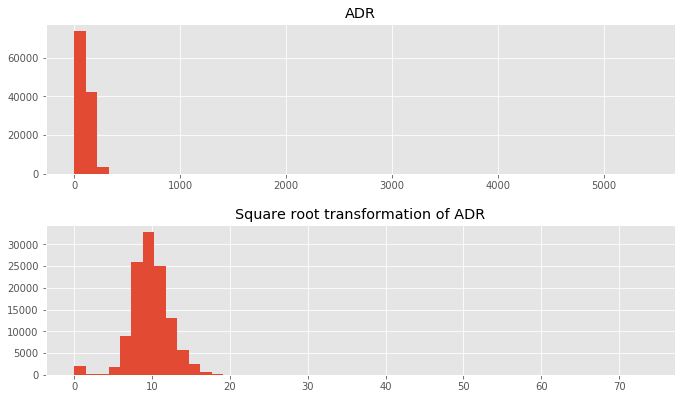

In [71]:
fig, ax = plt.subplots(2,figsize=(10,6))
fig.tight_layout(pad=3.0)
_ = ax[1].hist(data['adr_sqrt'], bins=50)
_ = ax[0].hist(data['adr'], bins=50)

ax[0].set_title('ADR')
ax[1].set_title('Square root transformation of ADR')

plt.show()

In [72]:
# apply sqrt tranformation for daily rate, skewness reduced to -0.38
data['lead_time_sqrt'] = np.sqrt(data.lead_time)
# replace NAN values
data.replace(np.nan, 0, inplace=True)

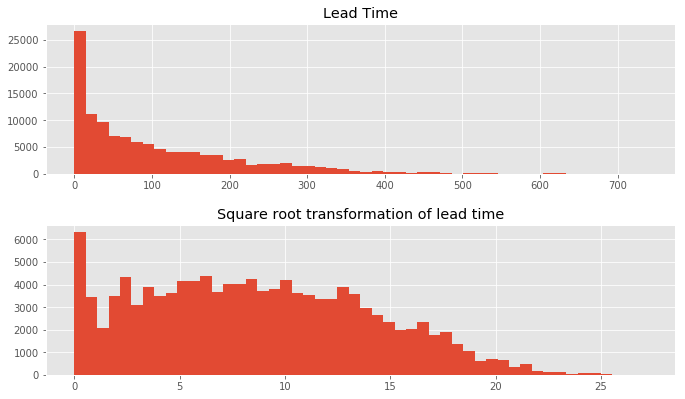

In [73]:
fig, ax = plt.subplots(2,figsize=(10,6))
fig.tight_layout(pad=3.0)
_ = ax[1].hist(data['lead_time_sqrt'], bins=50)
_ = ax[0].hist(data['lead_time'], bins=50)

ax[0].set_title('Lead Time')
ax[1].set_title('Square root transformation of lead time')

plt.show()

### Group low-frequency entries into 'other'

Country and agent have over 150 categories, where many are less than a few hundred representations in the data. To aid our Random Forest model in predicting a correct split, we will reduce the cardinality significantly. This will result in less information, but it will aid in preventing overfitting.

In [74]:
data[['country', 'market_segment', 'agent', 'reserved_room_type']] = data[['country', 'market_segment', 
                                                                           'agent', 'reserved_room_type']]\
                                                    .where(data[['country', 'market_segment', 'agent', 
                                                                 'reserved_room_type']]\
                                                    .apply(lambda x: x.map(x.value_counts()))>=2000, "other")

### Convert reserved room type to numeric using average price

In [75]:
# create average price column
data['avg_price_per_room'] = data[['adr']]\
                                          .groupby(data['reserved_room_type'])\
                                          .transform('mean')

In [76]:
group = data.groupby(['reserved_room_type', 'avg_price_per_room'])

df2 = group.apply(lambda x: x['avg_price_per_room'].unique())
pricing_per_room = pd.DataFrame(df2).drop(0, axis=1)

In [77]:
pricing_per_room

Empty DataFrame
Columns: []
Index: [(A, 90.76042918054331), (D, 120.6651850114668), (E, 124.3853472649046), (F, 167.68965136347904), (G, 175.99602674307576), (other, 136.62162101313285)]

In [78]:
# Map numeric to room type based on cost of room
d = {'A':1, 'D':2, 'E':3, 'other':4, 'F':5, 'G':6}
data.reserved_room_type = data.reserved_room_type.map(d)

### Grouped Plots

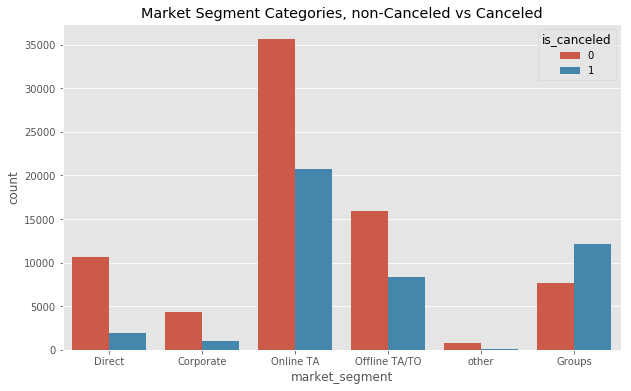

In [79]:
a4_dims = (10, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title('Market Segment Categories, non-Canceled vs Canceled')
_ = sns.countplot(x = 'market_segment', hue = 'is_canceled', data = data, ax = ax)

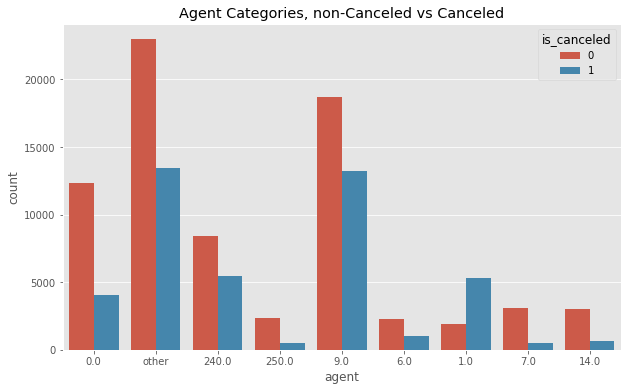

In [80]:
a4_dims = (10, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title('Agent Categories, non-Canceled vs Canceled')
_ = sns.countplot(x = 'agent', hue = 'is_canceled', data = data, orient = 'v', ax = ax)

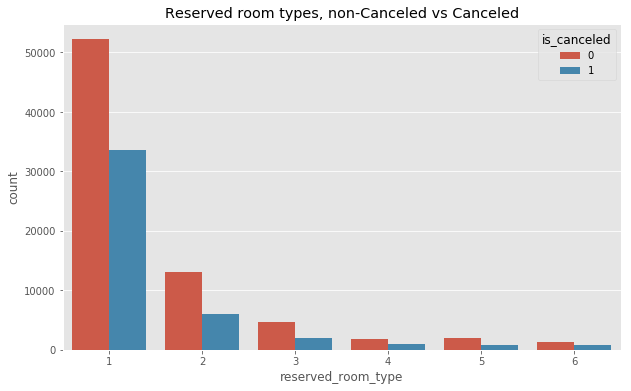

In [81]:
a4_dims = (10, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title('Reserved room types, non-Canceled vs Canceled')
_ = sns.countplot(x = 'reserved_room_type', hue = 'is_canceled', data = data, orient = 'v', ax = ax)

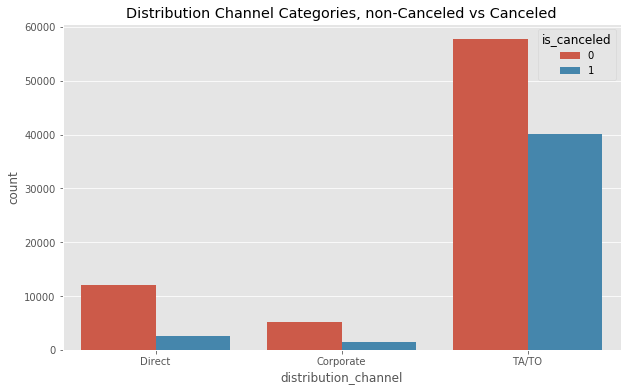

In [82]:
a4_dims = (10, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title('Distribution Channel Categories, non-Canceled vs Canceled')
_ = sns.countplot(x = 'distribution_channel', hue = 'is_canceled', data = data, orient = 'v', ax = ax)

### Data leakage

County is a source of data leakage. Bookings that fail to show up are often marked as being from the home country, it is not until the arrival that the nationality becomes more accurate. This results in an uneven distribution of canceled bookings from the home country which is innaccurate and misleading for the model. This can be observed in the plot below.

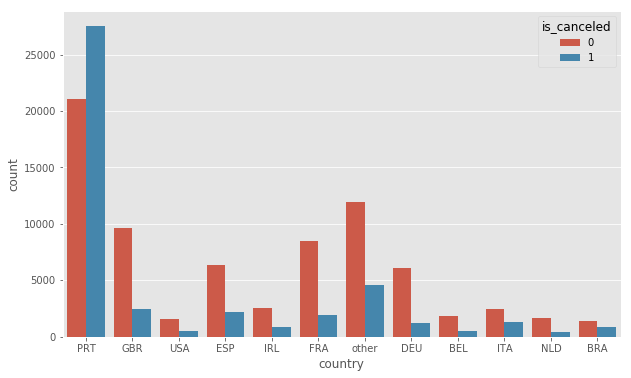

In [83]:
a4_dims = (10, 6)
fig, ax = plt.subplots(figsize=a4_dims)
_ = sns.countplot(x = 'country', hue = 'is_canceled', data = data, orient = 'v', ax = ax)

In [84]:
# drop country column to avoid data leakage
data = data.drop('country', axis=1)

### Final representation of numeric and categorical columns

In [85]:
# make repeated guest categorical
data.is_repeated_guest = data.is_repeated_guest.astype('object')

In [86]:
data.describe(exclude='O').T

count         mean         std  \
reserved_room_type              119190.0     1.522334    1.065791   
lead_time                       119190.0   104.151036  106.891978   
arrival_date_year               119190.0  2016.156137    0.707627   
arrival_date_month              119190.0     6.552983    3.089764   
arrival_date_week_number        119190.0    27.167254   13.601657   
arrival_date_day_of_month       119190.0    15.799119    8.780242   
previous_cancellations          119190.0     0.054401    0.226807   
previous_bookings_not_canceled  119190.0     0.030355    0.171563   
company                         119190.0     0.057018    0.231878   
days_in_waiting_list            119190.0     0.031026    0.173389   
adr                             119190.0   101.803392   50.541418   
is_canceled                     119190.0     0.370694    0.482993   
adr_sqrt                        119190.0     9.764296    2.542041   
lead_time_sqrt                  119190.0     8.660492    5.398810   
avg_price_per_room              119190.0   101.803392   20.056651   

                                        min          25%          50%  \
reserved_room_type                 1.000000     1.000000     1.000000   
lead_time                          0.000000    18.000000    69.000000   
arrival_date_year               2015.000000  2016.000000  2016.000000   
arrival_date_month                 1.000000     4.000000     7.000000   
arrival_date_week_number           1.000000    16.000000    28.000000   
arrival_date_day_of_month          1.000000     8.000000    16.000000   
previous_cancellations             0.000000     0.000000     0.000000   
previous_bookings_not_canceled     0.000000     0.000000     0.000000   
company                            0.000000     0.000000     0.000000   
days_in_waiting_list               0.000000     0.000000     0.000000   
adr                                0.000000    69.000000    94.500000   
is_canceled                        0.000000     0.000000     0.000000   
adr_sqrt                           0.000000     8.306624     9.721111   
lead_time_sqrt                     0.000000     4.242641     8.306624   
avg_price_per_room                90.760429    90.760429    90.760429   

                                        75%          max  
reserved_room_type                 2.000000     6.000000  
lead_time                        161.000000   737.000000  
arrival_date_year               2017.000000  2017.000000  
arrival_date_month                 9.000000    12.000000  
arrival_date_week_number          38.000000    53.000000  
arrival_date_day_of_month         23.000000    31.000000  
previous_cancellations             0.000000     1.000000  
previous_bookings_not_canceled     0.000000     1.000000  
company                            0.000000     1.000000  
days_in_waiting_list               0.000000     1.000000  
adr                              126.000000  5400.000000  
is_canceled                        1.000000     1.000000  
adr_sqrt                          11.224972    73.484692  
lead_time_sqrt                    12.688578    27.147744  
avg_price_per_room               120.665185   175.996027

In [87]:
data.describe(include='O').T

count unique         top    freq
hotel                 119190      2  City Hotel   79131
market_segment        119190      6   Online TA   56328
distribution_channel  119190      3       TA/TO   97869
customer_type         119190      4   Transient   89418
kids                  119190      2     no_kids  109861
babies                119190      2           0  118275
is_repeated_guest     119190      2           0  115383
agent                 119190      9       other   36445

## Logistic regression

We start with a basic logistic regression model pipped with a standard scalar to allow our features to be more digestible and comparable for the model algorithm. An appropriate measurement will be accuracy, which gives the percentage of correct predictions, and the area under the ROC curve which measures how well the model can differentiate between classes. The scores we receive from these measurements in our logistic regression classification model will be used as a benchmark for improvement.

In [88]:
# import scaling, scoring and machine learning modules
from sklearn.preprocessing import LabelEncoder
# split out testing set for validation
from sklearn.model_selection import train_test_split
# log reg model with processing steps
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# metrics of interest
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# for specificity vs sensitivity plots
from sklearn.metrics import roc_curve
# train with cross validation
from sklearn.model_selection import KFold

### Apply dummy coding techinques

Our logistic regression model can only handle numeric variables, while encoding the categorical features would produce numeric values it would create a false sense of order among categories. To avoid putting meaning to a randomly assigned order we will use pandas get_dummies which will split each category into its own column, made up of 0's and 1's to represent if it is relevant for that observation. To avoid correlated features we use the option "drop_first", which drops one column for each category (it isn't needed because it is easy to make the assumption that if no other categories are relevant, the dropped feature must be true).

In [89]:
# Dummy coding for col in dummy_cols
dummy_cols = ['customer_type', 'market_segment', 'distribution_channel', 'agent']
dummy_data = pd.get_dummies(data, columns=dummy_cols, prefix_sep = "_", drop_first=True)

In [90]:
# select columns that have been transformed, avoid overly correlated features and over generalizing features
log_reg_data = dummy_data[dummy_data.columns.difference(['lead_time', 'arrival_date_year', 'arrival_date_month',
                                                         'arrival_date_week_number', 'arrival_date_day_of_month', 
                                                         'adr', 'hotel', 'avg_price_per_room', 'kids', 
                                                         'distribution_channel_Undefined', 'distribution_channel_GDS',
                                                         'market_segment_other', 'avg_price_per_room', 'projected_arrival'])]

### Logistic Regression Data 

In [91]:
log_reg_data.head()

adr_sqrt  agent_1.0  agent_14.0  agent_240.0  agent_250.0  agent_6.0  \
0  0.000000          0           0            0            0          0   
1  0.000000          0           0            0            0          0   
2  8.660254          0           0            0            0          0   
3  8.660254          0           0            0            0          0   
4  9.899495          0           0            1            0          0   

   agent_7.0  agent_9.0  agent_other babies  ...  is_canceled  \
0          0          0            0      0  ...            0   
1          0          0            0      0  ...            0   
2          0          0            0      0  ...            0   
3          0          0            1      0  ...            0   
4          0          0            0      0  ...            0   

   is_repeated_guest  lead_time_sqrt  market_segment_Direct  \
0                  0       18.493242                      1   
1                  0       27.147744                      1   
2                  0        2.645751                      1   
3                  0        3.605551                      0   
4                  0        3.741657                      0   

   market_segment_Groups  market_segment_Offline TA/TO  \
0                      0                             0   
1                      0                             0   
2                      0                             0   
3                      0                             0   
4                      0                             0   

   market_segment_Online TA  previous_bookings_not_canceled  \
0                         0                               0   
1                         0                               0   
2                         0                               0   
3                         0                               0   
4                         1                               0   

  previous_cancellations  reserved_room_type  
0                      0                   4  
1                      0                   4  
2                      0                   1  
3                      0                   1  
4                      0                   1  

[5 rows x 27 columns]

### Split the Data into train and test

In [93]:
# Split data into features and label
# features X
X = log_reg_data.drop('is_canceled', axis=1)
        
# Label y
y = log_reg_data['is_canceled']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=3)

### Fit out of the box Logisitic Regression

In [94]:
# fit on training set
logreg = LogisticRegression(max_iter=10000).fit(X_train, y_train)
# predict on test set
y_pred = logreg.predict(X_test)
accuracy_score(y_test, y_pred)

0.7518667673462539

### Plot the ROC curve.

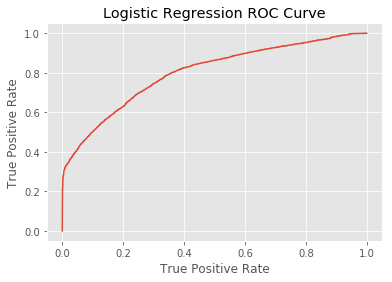

In [95]:
# plotting the ROC curve
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.xlabel('True Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [96]:
print(roc_auc_score(y_test, y_pred_prob))

0.800012122891967


> Our benchmark is a ~75% accuracy and an ~80% AUROC score. Let's create a more robust model with Kfold cross validation and attempt to improve the metrics with parameter tuning steps.

### Cross-validation accuracy score

In [97]:
def cv_score(clf, X, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    kf = KFold(nfold)
    for train, test in kf.split(X): # split data into train/test groups, 5 times
        clf.fit(X.iloc[train], y.iloc[train]) # fit
        result += score_func(y.iloc[test], clf.predict(X.iloc[test])) # evaluate score function on held-out data
    return result / nfold # average

In [98]:
# fit on training set
logreg = LogisticRegression(max_iter=10000).fit(X_train, y_train)
# predict on test set
y_pred = logreg.predict(X_test)

score = cv_score(logreg, X_train, y_train)
print(score)

0.7514472557039014


### Ridge (L1) and Lasso (L2) Feature Selection

In [99]:
def display_plot(cv_scores, cv_scores_std, alpha_space):
    '''This function will plot the r squared 
    score as well as standard error for each alpha'''
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, \
                cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

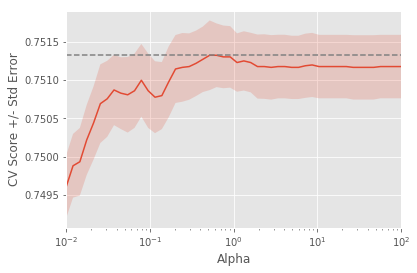

In [100]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-2, 2, 50)
ridge_scores = []
ridge_scores_std = []
results = pd.DataFrame(columns = ['ridge_cv_score', 'alpha'])

# Create a ridge regressor: ridge
ridge = LogisticRegression(penalty='l2', solver='saga', max_iter=10000)


# Compute scores over range of alphas
for alpha in alpha_space:
  
    # Specify the alpha value to use: ridge.alpha
    ridge.C = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_train.values, y_train.values, cv = 5)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # add to results dataframe
    new_row = {'ridge_cv_score': np.mean(ridge_cv_scores), 'alpha': alpha}
    results = results.append(new_row, ignore_index=True)
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

best_score = results.iloc[results.ridge_cv_score.idxmax()]['ridge_cv_score']
best_alpha_ridge = results.iloc[results.ridge_cv_score.idxmax()]['alpha']

# Display the plot
display_plot(ridge_scores, ridge_scores_std, alpha_space)

In [101]:
print("The top mean score is {}, with an alpha of {}".format(best_score, best_alpha_ridge))

The top mean score is 0.751321410179283, with an alpha of 0.6250551925273969


> Lasso may give us better results, as we are using a significant number of predictors at this point and zero-ing some out may be a better approach than dampening with ridge.

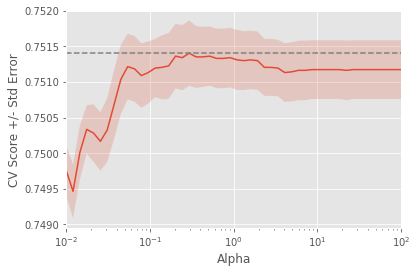

In [102]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-2, 2, 50)
lasso_scores = []
lasso_scores_std = []

results_lasso = pd.DataFrame(columns = ['lasso_cv_score', 'alpha'])

# Create a ridge regressor: ridge

lasso = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)

#y_reshape = np.ravel(y_train.values.reshape(-1,1))

# Compute scores over range of alphas
for alpha in alpha_space:
  
    # Specify the alpha value to use: ridge.alpha
    lasso.C = alpha

    # Perform 10-fold CV: ridge_cv_scores
    lasso_cv_scores = cross_val_score(lasso, X_train, y_train, cv = 5)

    # Append the mean of lasso_cv_scores to ridge_scores
    lasso_scores.append(np.mean(lasso_cv_scores))
    
    # add to results dataframe
    new_row = {'lasso_cv_score': np.mean(lasso_cv_scores), 'alpha': alpha}    
    results_lasso = results_lasso.append(new_row, ignore_index=True)

    # Append the std of ridge_cv_scores to ridge_scores_std
    lasso_scores_std.append(np.std(lasso_cv_scores))

best_score = results_lasso.iloc[results_lasso.lasso_cv_score.idxmax()]['lasso_cv_score']
best_alpha_lasso = results_lasso.iloc[results_lasso.lasso_cv_score.idxmax()]['alpha']

# Display the plot
display_plot(lasso_scores, lasso_scores_std, alpha_space)

In [103]:
print("The top mean score is {}, with an alpha of {}".format(best_score, best_alpha_lasso))

The top mean score is 0.7514053060958392, with an alpha of 0.29470517025518095


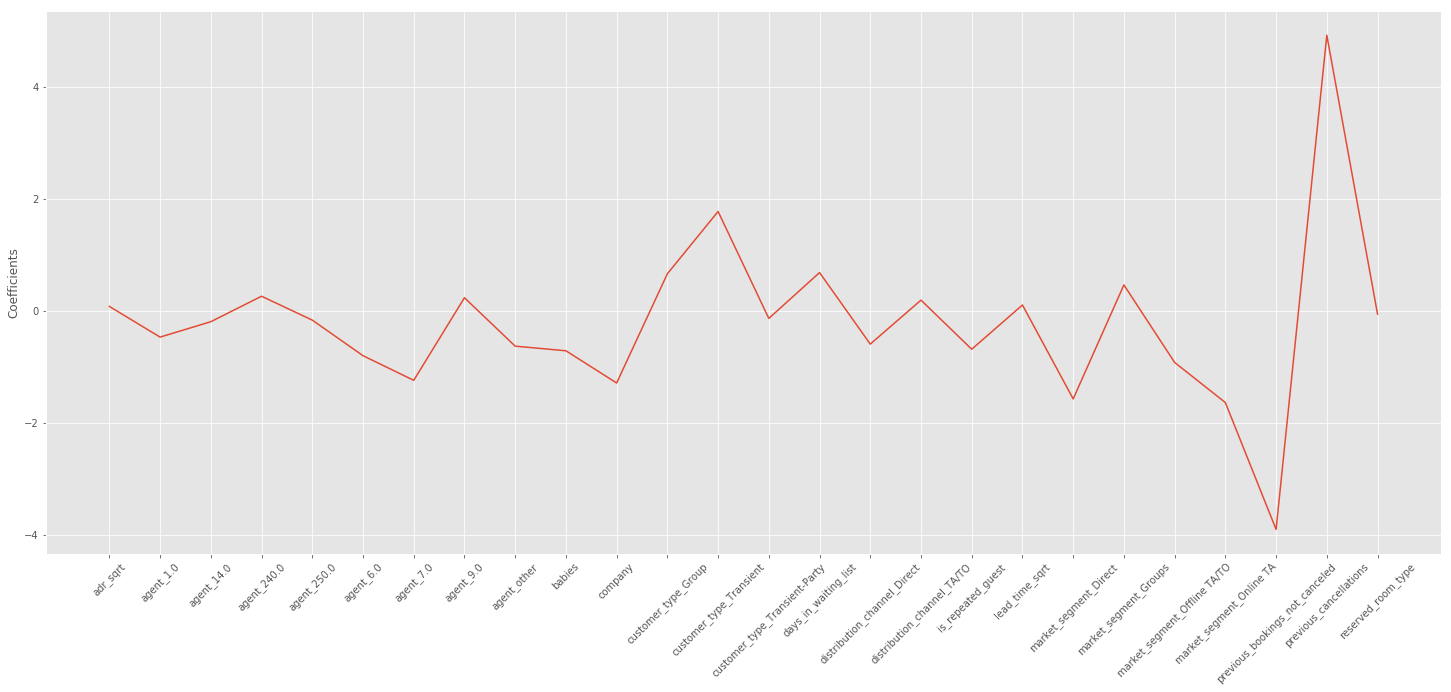

In [104]:
# Lasso for feature selection in scikit learn
#store feature names
from sklearn.linear_model import Lasso
names = X_train.columns
# extract coef attribute and store
lasso_tuned = LogisticRegression(penalty='l1', C = best_alpha_lasso, solver='saga', max_iter=10000)
lasso_coef = lasso_tuned.fit(X_train, y_train).coef_
_ = plt.figure(figsize=(25,10))
_ = plt.plot(range(len(names)), lasso_coef.T)
_ = plt.xticks(range(len(names)), names, rotation=45)
_ = plt.ylabel('Coefficients')
plt.show()

In [105]:
df = pd.DataFrame(data=lasso_coef.T, columns=['coefficients'])
df['feature'] = names
top_features = df[(df['coefficients'] > 1) | (df['coefficients'] < -1)]
print("Influential Features for Logistic Regression model:")
top_features

Influential Features for Logistic Regression model:


coefficients                         feature
6      -1.235811                       agent_7.0
10     -1.283515                         company
12      1.777418         customer_type_Transient
19     -1.567105           market_segment_Direct
22     -1.632327        market_segment_Online TA
23     -3.896306  previous_bookings_not_canceled
24      4.922747          previous_cancellations

> Feature selection with L2 penalty has put a lot of importance on binary features with clear correlations to cancellations. For example, agent 40 seems to produce bookings that rarely cancel, however there are very few guests who booked through this agent. Previous cancellations are another example, very few guests stayed with either hotel in the past, and even fewer have previous cancellations, but this is the most important feature identified by the model. 

### Final Logistic Regression Model using L1 regularization for eliminating non-contributing features

In [106]:
# fit on training set
log_reg_param = LogisticRegression(C= best_alpha_lasso, penalty='l1', solver='saga', max_iter=10000).fit(X_train, y_train)

# cross validation
score = cv_score(log_reg_param, X_train, y_train)
print("Cross-validation score: {}".format(score))

Cross-validation score: 0.7514787181849121


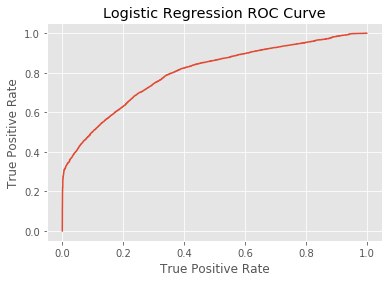

In [107]:
# plotting the ROC curve
y_pred_prob = log_reg_param.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.xlabel('True Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [108]:
# Print the accuracy and AUROC from the testing data.
print("Accuracy Score: ")
print(accuracy_score(y_test, log_reg_param.predict(X_test)))

print("AUROC Score: ")
print(roc_auc_score(y_test, y_pred_prob))

Accuracy Score: 
0.7520765164862824
AUROC Score: 
0.7998728025850825


The final accuracy score with our penalized model imporved very little from the out of box score. There were also some questionable choices for feature selection, most of the most influential were of low occurance. If we are fitting on data with very few of the important features, which would be more typical in a real world sense, the model would be a poor fit more often than not. 

Our next option will be to employ a Random Forest algorithm. There is no need for normalizing data in this approach but it will still benefit from dummy coding. Random forests are fast and interpretable, similar to logistic regression, but there is more potential for overfitting with this approach. 

### Random Forests

While our Logisitic Regression model fits our data quickly, it may be underfitting due to it's more simplistic approach. Our goal here is to get a realistic idea of whether a guest will cancel, we want our end model to therefore run quickly but also be able to distinguish between classes with relative confidence. Since we only need to identify guests who have a greater potential for cancellation, accuracy is not as important, as factors that go into cancellations are far more complex then what the scope of our data can provide. 

Moving from Logistic Regression, our next attempt will be to fit with a Random Forest Classifier. This will improve the usability of the model because of it's ability to handle non-linear features and outliers. The data we use will not have to be binned or scaled, making it useful for raw data to be plugged and predicted in the web app and for general use by hotel personel. The final model with tuning will most likely overfit however, to combat this we will do some feature selection with sci-kit learns permutation importance method and will prioritize usability over small metric improvements.

In [109]:
# import necessary modules
from sklearn.ensemble import RandomForestClassifier
# model report modules
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# cross validation to prevent overfitting
from sklearn.model_selection import cross_val_score
# hyperparameter tuning 
from sklearn.model_selection import RandomizedSearchCV

In [110]:
# select columns that have been transformed, avoid overly correlated features and over generalizing features
rf_data = dummy_data[dummy_data.columns.difference(['lead_time_sqrt','adr_sqrt','hotel',  
                                                         'reserved_room_type', 'kids', 
                                                         'distribution_channel_Undefined', 
                                                         'distribution_channel_GDS', 'market_segment_other',
                                                         'avg_price_per_room', 'projected_arrival'])]

In [111]:
# Split data into features and label
# features X
X = rf_data.drop('is_canceled', axis=1)
        
# Label y
y = rf_data['is_canceled']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=3)

### Default parameter Random Forest classifier

In [112]:
# Random Forest out of the box
rfc = RandomForestClassifier(random_state=94)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

print("Accuracy Score: ")
print(accuracy_score(y_test, y_pred))

[[13467  1572]
 [ 2423  6376]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87     15039
           1       0.80      0.72      0.76      8799

    accuracy                           0.83     23838
   macro avg       0.82      0.81      0.82     23838
weighted avg       0.83      0.83      0.83     23838

Accuracy Score: 
0.8324104371172079


### Plot Random Forests ROC curve

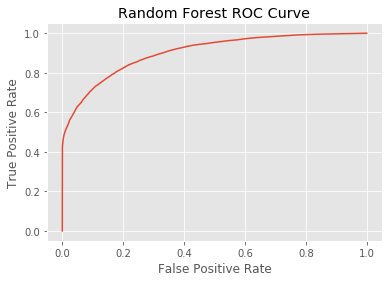

In [113]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import roc_curve

# plotting the ROC curve
y_pred_prob = rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [114]:
print("AUROC Score: ")
print(roc_auc_score(y_test, y_pred_prob))

AUROC Score: 
0.9025006740628702


> Immediately we see a significant improvement with Random Forests. Our accuracy score jumped from 75% to 83% and our AUROC improved from 80% to 90%. This is significant and will be noted as our benchmark from here, our next steps will attempt to simplify the model while maintaining our key measurements. In the end, usability in terms of speed and features need to be kept in mind along with the models ability to distinguish between classes. 

### Feature selection using permutation importance

In order to reduce the complexity of the model and make it more usable for deployment, we need to select only the features that are relevant to predicting cancellations. Random Forests has two methods of computing importance, impurity based and permutation. Since our data consists of some high cardinality categorical features, it is best to use permutation as impurity based selection is biased towards these types of features [[Permutation Importance vs Random Forest Feature Importance]](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html). Based on the results here, we can move forward with tuning and finalize our model for production. 

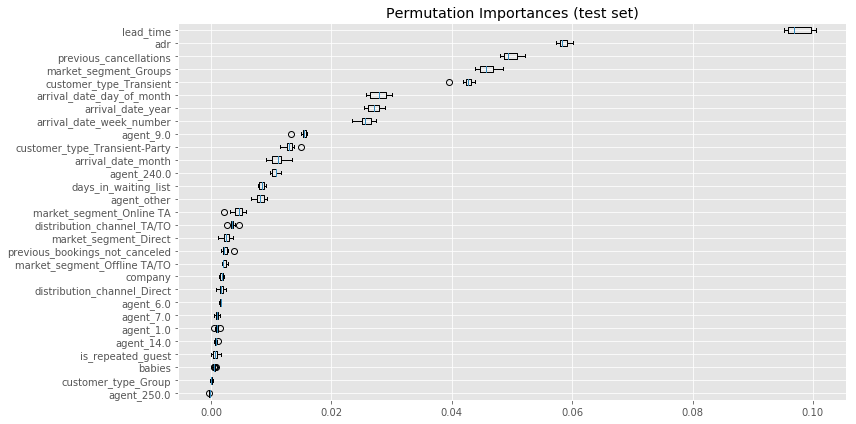

In [115]:
# import permutation importance
from sklearn.inspection import permutation_importance

result = permutation_importance(rfc, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

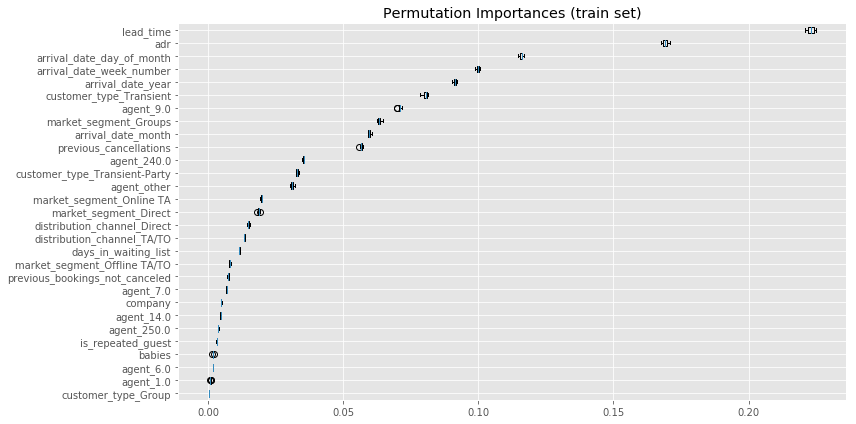

In [116]:
result = permutation_importance(rfc, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

> Our training set seems to be overfitting on the date of arrival but a number of other features share common importance. Lead time and average daily rate seem to be dominating the models evaluation. Our selected features for our next model will be a mix of features that are observed as significant in the plots above mixed with features identified as important from the exploratory phase, such as online travel agency bookings and direct bookings.

### Re-run model with selected features

In [117]:
# select columns that have been transformed, avoid overly correlated features and over generalizing features
rfc_selected = dummy_data[['previous_cancellations', 'lead_time', 'customer_type_Transient', 
                                'market_segment_Groups', 'adr', 'customer_type_Transient-Party', 
                               'arrival_date_week_number', 'previous_bookings_not_canceled', 'arrival_date_year',
                               'market_segment_Online TA', 'market_segment_Direct', 'agent_9.0', 'is_canceled']]

In [118]:
print("selected features dataframe:")
rfc_selected.head()

selected features dataframe:


previous_cancellations  lead_time  customer_type_Transient  \
0                       0        342                        1   
1                       0        737                        1   
2                       0          7                        1   
3                       0         13                        1   
4                       0         14                        1   

   market_segment_Groups   adr  customer_type_Transient-Party  \
0                      0   0.0                              0   
1                      0   0.0                              0   
2                      0  75.0                              0   
3                      0  75.0                              0   
4                      0  98.0                              0   

   arrival_date_week_number  previous_bookings_not_canceled  \
0                        27                               0   
1                        27                               0   
2                        27                               0   
3                        27                               0   
4                        27                               0   

   arrival_date_year  market_segment_Online TA  market_segment_Direct  \
0               2015                         0                      1   
1               2015                         0                      1   
2               2015                         0                      1   
3               2015                         0                      0   
4               2015                         1                      0   

   agent_9.0  is_canceled  
0          0            0  
1          0            0  
2          0            0  
3          0            0  
4          0            0

In [119]:
# Split data into features and label
# features X
X = rfc_selected.drop('is_canceled', axis=1)
        
# Label y
y = rfc_selected['is_canceled']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=3)

### Default parameter Random Forest classifier

In [121]:
# Random Forest out of the box
rfc1 = RandomForestClassifier(random_state=94)
rfc1.fit(X_train, y_train)
y_pred = rfc1.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

print("Accuracy Score with selected features: ")
print(accuracy_score(y_test, y_pred))

[[13351  1688]
 [ 2549  6250]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     15039
           1       0.79      0.71      0.75      8799

    accuracy                           0.82     23838
   macro avg       0.81      0.80      0.80     23838
weighted avg       0.82      0.82      0.82     23838

Accuracy Score with selected features: 
0.8222585787398272


### Feature importance for selected features

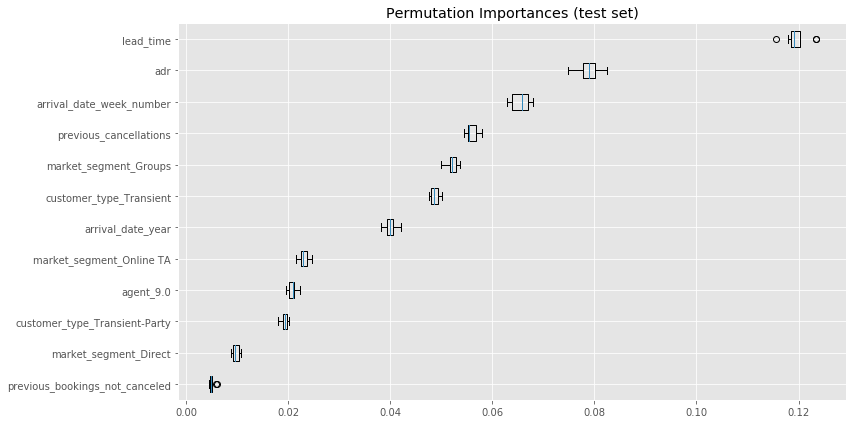

In [122]:
# import permutation importance
from sklearn.inspection import permutation_importance

result = permutation_importance(rfc1, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### Plot Random Forests ROC curve

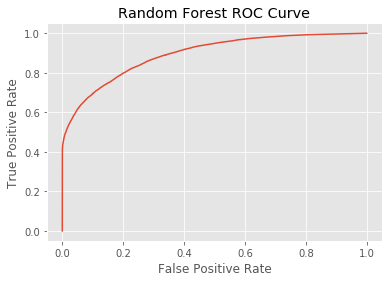

In [123]:
# plotting the ROC curve
y_pred_prob = rfc1.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [124]:
print("AUROC Score: ")
print(roc_auc_score(y_test, y_pred_prob))

AUROC Score: 
0.893151220472262


We have sacrificed a minor drop in accuracy and AUROC score for limiting our features from 36 to 11. The complexity of the model has dropped significantly which will help with processing speed and interpretability. We can see now the importance of features not previously considered, like average daily rate and arrival date; these are now seen as significant indicators of a potential cancellation.

### Cross-validation with default parameters and selected features

In [125]:
# run cross validation
rfc_cv_score = cross_val_score(rfc1, X_train, y_train, cv=5, scoring='roc_auc')

# fit model
rfc1.fit(X_train, y_train)

# create prediction set
rfc_predict = rfc1.predict(X_test)

In [126]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean CV AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[13351  1688]
 [ 2549  6250]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     15039
           1       0.79      0.71      0.75      8799

    accuracy                           0.82     23838
   macro avg       0.81      0.80      0.80     23838
weighted avg       0.82      0.82      0.82     23838



=== All AUC Scores ===
[0.88497734 0.88482791 0.88769668 0.88378578 0.88552145]


=== Mean CV AUC Score ===
Mean AUC Score - Random Forest:  0.8853618291543656


In [127]:
y_pred_prob = rfc1.predict_proba(X_test)[:,1]
print("AUROC Score for validation set: ")
print(roc_auc_score(y_test, y_pred_prob))

AUROC Score for validation set: 
0.893151220472262


> Our cross-validated AUROC score is around our 90% benchmark with only a minor overall loss from reducing the number of features. 

### Hyperparameter tuning with RandomizedSearchCV

We may be able to see greater improvement from searching through parameters for our random forest model. The cost of running our randomized search is that our model may overfit and run slower than preferred. If the results from the search show significant enough improvement however, the trade-off may be worth the ability to predict and understand factors that go into potential cancellations. 

In [128]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)],# Number of trees in random forest
                'max_features': ['auto', 'sqrt'],# Number of features to consider at every split
                'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],# Maximum number of levels in tree
                'min_samples_split': [2, 5],# Minimum number of samples required to split a node
                'min_samples_leaf': [1, 2, 4],# Minimum number of samples required at each leaf node 
                'bootstrap': [True, False]}# Method of selecting samples for training each tree


# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc1, param_distributions = random_grid, cv = 5, random_state=42)
# Fit the model
rfc_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [129]:
# print results
print("Best Parameters:\n")
print(rfc_random.best_params_)

Best Parameters:

{'n_estimators': 644, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}


In [130]:
# Implementing parameter tuning, Random Forest Tuned (rfc_tnd)
rfc_tnd = rfc_random.best_estimator_

y_pred = rfc_tnd.predict(X_test)

In [131]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

print("Accuracy Score: ")
print(accuracy_score(y_test, y_pred))

[[13492  1547]
 [ 2713  6086]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86     15039
           1       0.80      0.69      0.74      8799

    accuracy                           0.82     23838
   macro avg       0.81      0.79      0.80     23838
weighted avg       0.82      0.82      0.82     23838

Accuracy Score: 
0.8212937326956959


### Plot Tuned Random Forests ROC curve

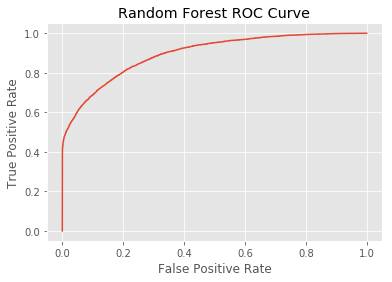

In [132]:
# plotting the ROC curve
y_pred_prob = rfc_tnd.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [133]:
print("Tuned AUROC Score:\n")
print(roc_auc_score(y_test, y_pred_prob))

Tuned AUROC Score:

0.8953199274038124


Little improvement was observed with parameter tuning using Random Forests. The final model is costly in run time and may slow down our web application. A faster model that does well with categorical features is catboost, we will explore results with this model next and utilize its feature importance visualizations to understand the impact of each.

### Gradient Boosting

In [126]:
from sklearn.ensemble import GradientBoostingClassifier

# Learning rate to fit over, keeping hyperparameters from before
lr_list = [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators = 1200, learning_rate=learning_rate, min_samples_split = 10, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 50, random_state = 3)
    gb_clf.fit(X_train, y_train)
    
    print("Learning rate: ", learning_rate)

    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.01
Accuracy score (validation): 0.861
Learning rate:  0.025
Accuracy score (validation): 0.859
Learning rate:  0.05
Accuracy score (validation): 0.859
Learning rate:  0.075
Accuracy score (validation): 0.858
Learning rate:  0.1
Accuracy score (validation): 0.857
Learning rate:  0.25
Accuracy score (validation): 0.856
Learning rate:  0.5
Accuracy score (validation): 0.854
Learning rate:  0.75
Accuracy score (validation): 0.854
Learning rate:  1
Accuracy score (validation): 0.695


In [127]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Implement gradient boosting with all tuned hyperparameters, including an optimal learning rate of 0.25
gb_clf2 = GradientBoostingClassifier(n_estimators = 1200, learning_rate=0.01, min_samples_split = 10, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 50, random_state = 3)
gb_clf2.fit(X_train, y_train)

gb_clf2_cv_score = cross_val_score(gb_clf2, X_train, y_train, cv=5, scoring='roc_auc')
gb_clf2_predict = gb_clf2.predict(X_test)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, gb_clf2_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, gb_clf2_predict))
print('\n')
print("=== All AUC Scores ===")
print(gb_clf2_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", gb_clf2_cv_score.mean())

=== Confusion Matrix ===
[[13546  1493]
 [ 1832  6967]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     15039
           1       0.82      0.79      0.81      8799

    accuracy                           0.86     23838
   macro avg       0.85      0.85      0.85     23838
weighted avg       0.86      0.86      0.86     23838



=== All AUC Scores ===
[0.93630227 0.93650004 0.93784495 0.93385547 0.93879803]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.936660153277219


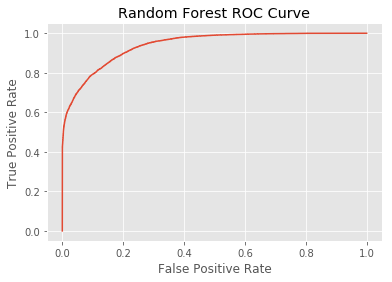

In [128]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import roc_curve

# plotting the ROC curve
y_pred_prob = gb_clf2.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [129]:
print("Accuracy Score: ")
print(accuracy_score(y_test, gb_clf2_predict))

print("AUROC Score: ")
print(roc_auc_score(y_test, y_pred_prob))

Accuracy Score: 
0.8605168218810303
AUROC Score: 
0.9405173551833764


### Catboost classification model

Catboost is an excellent machine learning classifier for explainability and has a faster implementation which will be helpful for quick predictions. Even better, the Catboost algorithm handles categorical features without the need for transformation. This significantly improves the usability, given that when it is used in the web app, there will be no need to process inputs from the user interface. If we can achieve comparable metrics with this model it may be our best route for deployment of the model.

In [134]:
# Catboost model with cross validation
from catboost import CatBoostClassifier, Pool, cv
# visualize parameter adjustments
from catboost import MetricVisualizer

In [135]:
# select columns that have been transformed, avoid overly correlated features and over generalizing features
catboost_data = dummy_data[dummy_data.columns.difference(['lead_time_sqrt','adr_sqrt','hotel',  
                                                         'reserved_room_type', 'kids', 
                                                         'distribution_channel_Undefined', 
                                                         'distribution_channel_GDS', 'market_segment_other',
                                                         'avg_price_per_room', 'projected_arrival'])]

The data we will use will be the same as the start of our Random Forest model. We will go through the same steps as before by running the model with all features of interest and then reducing the number of features by looking at their importance. Catboost is unique in that it's feature importances can be plotted individually and evaluated against other features. This is a significant advantage for reporting not just what features are significant but for what values they tend to produce cancellations. 

In [136]:
y = catboost_data.is_canceled
X = catboost_data.drop('is_canceled', axis=1)

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.80, random_state=42)

In [137]:
categorical_features_indices = np.where((X.dtypes != np.float) & (X.dtypes != np.int))[0]

### Fit out of the box

In [138]:
#Model training
model = CatBoostClassifier(
    custom_loss=['AUC', 'Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [139]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Cross-validation

In [140]:
#Cross validation
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [141]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
max_auc = np.max(cv_data['test-AUC-mean'])
max_accuracy = np.max(cv_data['test-Accuracy-mean'])
print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)
print("Best AUROC:\n")
print(max_auc)
print("Best Accuracy: \n")
print(max_accuracy)

Best validation Logloss score, not stratified: 0.4206±0.0031 on step 999
Best AUROC:

0.8655387984070222
Best Accuracy: 

0.7913332072580977


/Users/mattmerrill/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


### Feature Importance

In [142]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=categorical_features_indices))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


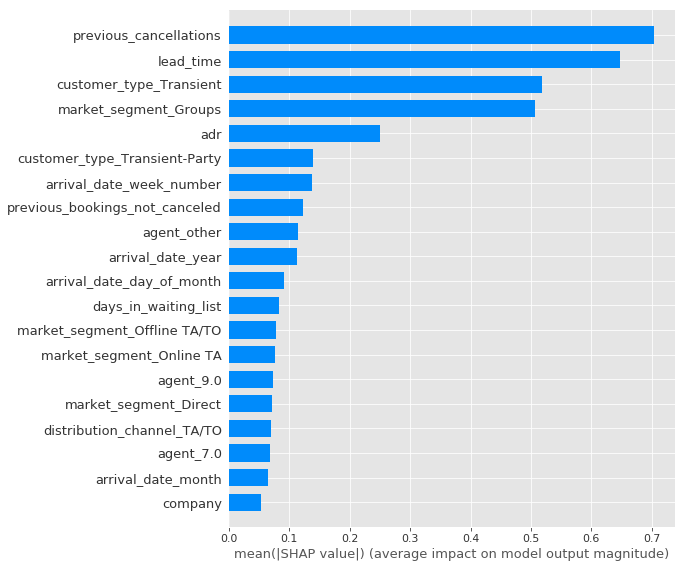

In [143]:
# feature importance plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

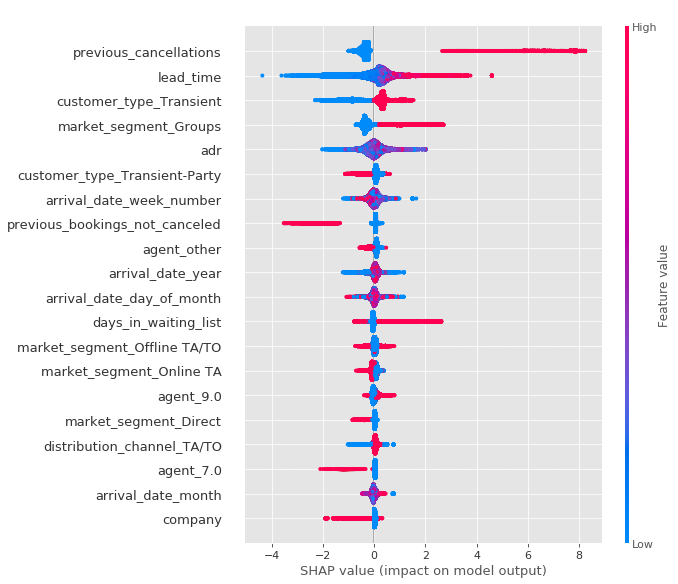

In [144]:
shap.summary_plot(shap_values, X_train)

> The results of the shap summary plot reveal how each feature impacts the model output. Each dot represents a prediction, with red indicating a high feature value and blue a low feature value. Dots to the right show a positive impact, meaning a higher probability of canceling and dots to the left indicate lower probability of canceling. We can conclude here that higher lead time and previous cancellations correlate to a greater possibility that a customer will cancel. 

> From the findings above we will take the top influential features to run the model again. Some features that do not show strong importance will be used because of the discoveries made during the exploratory analysis phase. Although online TA and direct bookings are not high on the list, these were of clear importance in our exploratory plots. 

### Final dataframe for catboost model

In [145]:
catboost_data_selected1 = catboost_data[['previous_cancellations', 'lead_time', 'customer_type_Transient', 
                                'market_segment_Groups', 'adr', 'customer_type_Transient-Party', 
                               'arrival_date_week_number', 'previous_bookings_not_canceled', 'arrival_date_year',
                               'market_segment_Online TA', 'market_segment_Direct', 'agent_9.0', 'is_canceled']]

In [146]:
catboost_data_selected1.rename(columns={'customer_type_Transient-Party': 'customer_type_Transient_Party', 
                                        'market_segment_Online TA': 'market_segment_Online_TA'}, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [147]:
catboost_data_selected1.head()

previous_cancellations  lead_time  customer_type_Transient  \
0                       0        342                        1   
1                       0        737                        1   
2                       0          7                        1   
3                       0         13                        1   
4                       0         14                        1   

   market_segment_Groups   adr  customer_type_Transient_Party  \
0                      0   0.0                              0   
1                      0   0.0                              0   
2                      0  75.0                              0   
3                      0  75.0                              0   
4                      0  98.0                              0   

   arrival_date_week_number  previous_bookings_not_canceled  \
0                        27                               0   
1                        27                               0   
2                        27                               0   
3                        27                               0   
4                        27                               0   

   arrival_date_year  market_segment_Online_TA  market_segment_Direct  \
0               2015                         0                      1   
1               2015                         0                      1   
2               2015                         0                      1   
3               2015                         0                      0   
4               2015                         1                      0   

   agent_9.0  is_canceled  
0          0            0  
1          0            0  
2          0            0  
3          0            0  
4          0            0

### Re-run model with selected features

In [148]:
y = catboost_data_selected1.is_canceled
X = catboost_data_selected1.drop('is_canceled', axis=1)

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

In [149]:
categorical_features_indices = np.where((X.dtypes != np.float) & (X.dtypes != np.int))[0]

#Model training
model = CatBoostClassifier(
    custom_loss=['AUC', 'Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose'
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [150]:
#Cross validation
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [151]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
max_auc = np.max(cv_data['test-AUC-mean'])
max_accuracy = np.max(cv_data['test-Accuracy-mean'])
print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)
print("Best AUROC:\n")
print(max_auc)
print("Best Accuracy: \n")
print(max_accuracy)

Best validation Logloss score, not stratified: 0.4349±0.0042 on step 999
Best AUROC:

0.8547546576309824
Best Accuracy: 

0.7840339109958016



The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


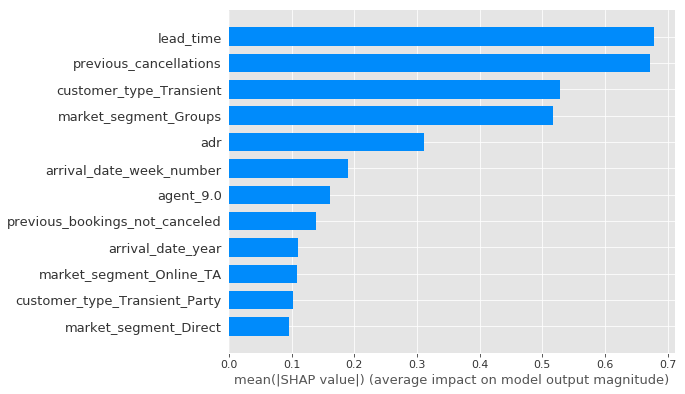

In [152]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=categorical_features_indices))
# feature importance plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

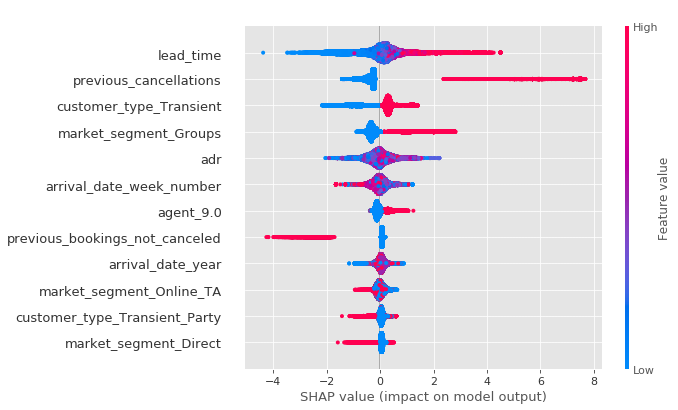

In [153]:
shap.summary_plot(shap_values, X_train)

> Our initial model with selected features is putting a lot of importance on lead time and previous cancellations. We can see the benefit of using dummy coding to separate specific aspects of a customer's booking details. It is clear that transient bookings are more likely to cancel along with those who booked with a group tour. Something interesting to point out here is that our model is seeing OTA bookings as having greater influence on a customer not cancelling than previously thought. This could be due to the fact that OTA bookings are often made with little lead time, and as we can see, shorter lead times are highly correlated to non-canceled bookings. It will be interesting to see however, how customers who booked through an OTA with a large lead time are interpreted by the model. First however, we need to improve our model by selecting the learning rate and increasing the number of iterations.

### Tune Catboost Model with selected features

To tune our model we must select the learning rate, which works in hand with the number of iterations. Since our model requires more iterations to reach the best prediction our learning rate will be relatively low. We will test two learning rates, 0.2 and 0.5, to see which produces the best outcome. In the end however, if our model does not show much improvement, speed will be prefered over a minor metric improvement.

In [171]:
model_selected1 = CatBoostClassifier(
    learning_rate=0.2,
    iterations=4000,
    random_seed=0,
    custom_loss=['AUC', 'Accuracy'],
    logging_level='Silent',
    train_dir='learing_rate_0.2'
)

model_selected2 = CatBoostClassifier(
    learning_rate=0.05,
    iterations=4000,
    random_seed=0,
    custom_loss=['AUC', 'Accuracy'],
    logging_level='Silent',
    train_dir='learing_rate_0.05'
)
model_selected1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=categorical_features_indices,
    verbose=False
)
model_selected2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=categorical_features_indices,
    verbose=False
)

In [172]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.2', 'learing_rate_0.05']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Run with optimal learning rate

In [157]:
categorical_features_indices = np.where((X.dtypes != np.float) & (X.dtypes != np.int))[0]

model_final = CatBoostClassifier(
    iterations=4000,
    random_seed=63,
    learning_rate=0.2,  # learning rate of 0.2 from tuning step
    custom_loss=['AUC', 'Accuracy'],
    logging_level='Silent'
#     use_best_model=False
)
model_final.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [158]:
print('Tree count: ' + str(model_final.tree_count_))

Tree count: 2651


### Cross-validation data

In [173]:
params = model_final.get_params()
params['loss_function'] = 'Logloss'
params['iterations'] = 4000
params['custom_loss'] = ['AUC', 'Accuracy']
params['random_seed'] = 63
params['learning_rate'] = 0.2

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=categorical_features_indices),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [174]:
cv_data.head()

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0           0.608172          0.000587            0.608061   
1           1           0.563816          0.000670            0.563690   
2           2           0.539643          0.001018            0.539468   
3           3           0.520762          0.001727            0.520465   
4           4           0.510199          0.001954            0.509835   

   train-Logloss-std  test-AUC-mean  test-AUC-std  test-Accuracy-mean  \
0           0.000538       0.780183      0.002027            0.742663   
1           0.000315       0.789764      0.002386            0.745784   
2           0.000447       0.797943      0.002376            0.746397   
3           0.000412       0.802223      0.002803            0.747168   
4           0.000981       0.805183      0.002838            0.748100   

   test-Accuracy-std  train-Accuracy-mean  train-Accuracy-std  
0           0.002469             0.742774            0.000650  
1           0.002633             0.745843            0.000740  
2           0.002580             0.746392            0.000785  
3           0.002753             0.747286            0.000682  
4           0.002952             0.748779            0.001479

In [175]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
max_auc = np.max(cv_data['test-AUC-mean'])
max_accuracy = np.max(cv_data['test-Accuracy-mean'])
print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)
print("Best AUROC:\n")
print(max_auc)
print("Best Accuracy: \n")
print(max_accuracy)

Best validation Logloss score, not stratified: 0.3977±0.0030 on step 2471
Best AUROC:

0.8817085970998374
Best Accuracy: 

0.8108901753502812



The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


In [176]:
cv_data.iloc[2230,]

iterations             2230.000000
test-Logloss-mean         0.397786
test-Logloss-std          0.002800
train-Logloss-mean        0.298056
train-Logloss-std         0.000861
test-AUC-mean             0.880097
test-AUC-std              0.001833
test-Accuracy-mean        0.807182
test-Accuracy-std         0.003972
train-Accuracy-mean       0.873374
train-Accuracy-std        0.000454
Name: 2230, dtype: float64

### Feature importance

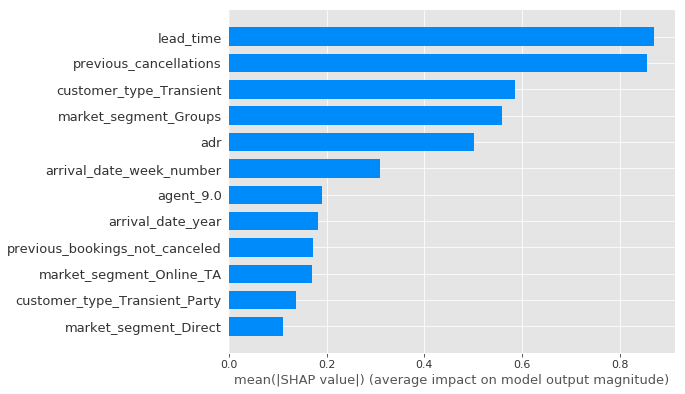

In [163]:
import shap
explainer = shap.TreeExplainer(model_final)
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=categorical_features_indices))
# feature importance plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

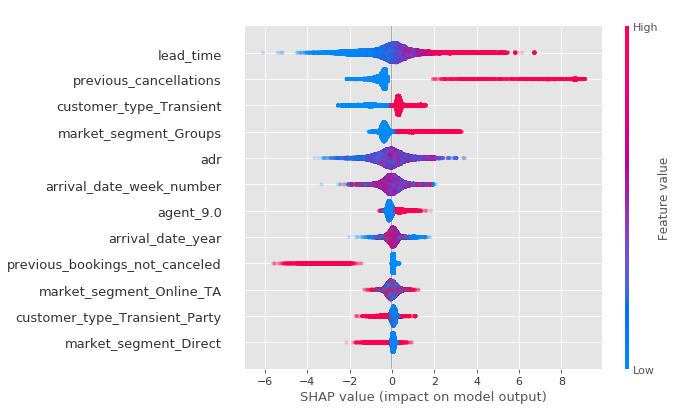

In [164]:
shap.summary_plot(shap_values, X_train, alpha=0.2)

> Increasing the iterations and selecting the learning rate has significantly improved our model. The summary plot of our tuned model has also revealed some changes to its interpretation. We can see now that direct bookings and transient party bookings have centered, implying less importance than previously thought. The model has also started to interpret OTA bookings as more influential towards cancellations than before. Next we will gain some insight into each of the important features identified and their relationship to other features using the dependency plot option in shap.

### Feature Dependencies

The dependency plot is a useful tool for interpreting the features that are most influential for our final model. Similar to summary plot, each point represents a booking, with the location based on the shap value. If the shap value is negative, the feature is more important in predicting non-canceled bookings, if it is positive then it would imply the opposite. For our most important predictors we want to get an idea of what is driving cancellations.

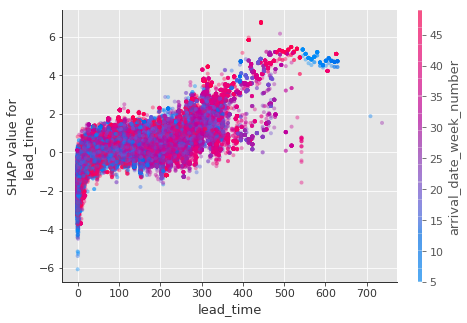

In [165]:
shap.dependence_plot("lead_time", 
                     shap_values, 
                     X_train, 
                     alpha=0.4, 
                     interaction_index="arrival_date_week_number")

> The color of the plot is labeled as relating to bookings made through an OTA, with red meaning the guest did use this means of booking. What we can see is a high correlation between bookings with larger lead times and potential for cancellation, reaching far above neutral after about that one year mark. We can also see that bookings with very little lead time often are followed through with. It looks like OTA bookings make up much of the lower lead time bookings, but when the lead time increases past about 200 days, OTA bookings seem to have an increased risk of cancellation. This is an interesting observation, it seems that OTA bookings greater than 200 days have a higher risk of cancellation than other means. 

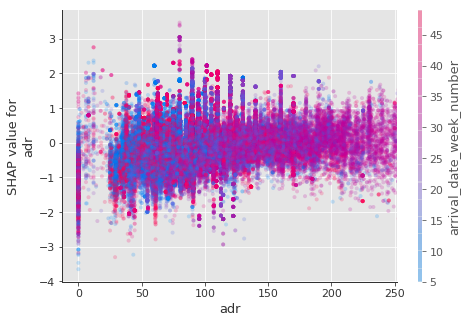

In [166]:
shap.dependence_plot("adr", 
                     shap_values, 
                     X_train, 
                     xmin="percentile(1)", 
                     xmax="percentile(99)", 
                     alpha=0.2,
                     interaction_index="arrival_date_week_number")

> The plot above displays the average daily rate, with the hue related to the week of arrival. There is a slight increase in the shap value with the hue changing towards the red as the daily rate increases. There is much more variation in cancellations for ADR's up to 150, with the hue also dominated by blue, implying earlier weeks in the year. The plot suggests an increased risk of cancellation for bookings with a higher ADR, but only slightly. It is also apparent that bookings with a low ADR are more likely to be followed through with, with free bookings almost never being canceled. 

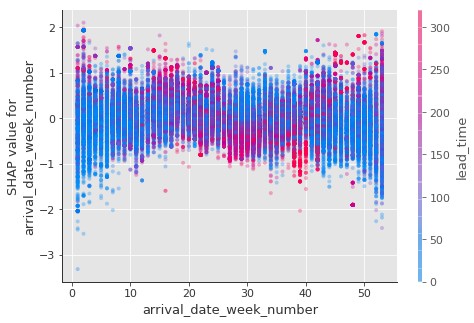

In [167]:
shap.dependence_plot("arrival_date_week_number", 
                     shap_values, 
                     X_train,
                     alpha=0.3,
                     interaction_index="lead_time")

> The plot above displays the week of arrival vs the lead time. Something that is immediately observed is the shape of the plot, with more variability towards the beginning and end of the year and more concentrated points during summer months. Bookings considered a potential for cancellation are above zero, with less risky bookings below zero. An interesting feature can be observed between week 10 and week 50, bookings with a greater lead time make a "u" shape, starting above zero in spring, dipping below zero during the summer months and increasing above zero again as fall and winter approach. This points to a seasonal trend in the influence of lead time. Booking further out is conducive to cancellations except in the summer months. 

### Export final model for web application

Our catboost model makes the final cut because of it's interpretability, speed and ability to handle categorical features. The shap library allowed us to understand which featrues are influencing predictions and how they relate individually with each other. This is an advantage that cannot be matched with our random forest model. With the catboost model we have the ability to adapt to changes in the booking industry as well, as new features become available our model will be able to adapt and run efficiently for quick prediction and outreach. We will export the model as a pickle file for our hotel explorer web app as our final step. 

In [168]:
import joblib

filename = '/Users/mattmerrill/Springboard/Capstone/HotelExplorer_2/finalized_model.pkl'
joblib.dump(model_final, filename)

['/Users/mattmerrill/Springboard/Capstone/HotelExplorer_2/finalized_model.pkl']

## Conclusion

Our catboost model was chosen for it's interpretability and speed. The model produced an accuracy of approximately 81% and an AUROC of about an 88%. The most important aspect of our model is its ability to distinguish between classes, so the AUROC is our metric of choice. At 88%, this should give us a good idea of which guests are likely to cancel and allow our client to predict in real time if incoming bookings are likely to be cancelled. Along with this, we also have a strong intuition for what factors play a role in cancelled and non-cancelled bookings. 

The most important indicator turned out to be lead time, with greater lead times leading to an increased likelihood for a cancellation. An unexpected factor was the week of arrival, while difficult to interpret from the shap summary, with our dependency plot we could see how it correlates with lead time to dynamically influence cancellations throughout popular seasons. Our model also illustrated the importance of market segment, with direct, group and online travel agency bookings making the final cut as influential factors. While group bookings and direct bookings showed clear connections with high potential for cancellation and non-cancellation, respectively, online travel agencies turned out to be more dynamic than previously assumed. 

In our original proposal, it was hypothesized that online travel agency bookings would play the greatest role in cancellations due to the advertisement of "risk free cancellations" among many of them. In our final model, online travel agencies played a minor role in cancellations overall. However, when OTA's are plotted with lead time, we can see that OTA bookings made with greater lead times tend to cancel more often, but bookings with shorter lead times are typically followed through with.

Among canceled and non-canceled bookings we can create a profile of a few key factors that make each more likely. For example, guests with extremely short lead times (last minute bookings) and relatively low average daily rates are very likely to follow through and arrive for their booking. Our profile of a guest likely to cancel can come in many forms, one example is a guest who books with an extremely large lead time coupled with an expensive average room rate. Cancellations also occur more often for greater lead times in the winter seasons. 

The implications of this work bring a myriad of options to lower overall cancellation rate, increase actualized income and improve customer experience for hotels. With the ability to distinguish between possible cancellations early on, hotels can create a focused effort towards preventing canceled bookings. This would result in an immediate net increase in actualized daily income and would incentivize early outreach to future travelers. One example of this would be to reach out to high risk bookings with discounted packages, perks and early options to customize stay details. Hotels can now be the ones taking advantage of the online travel agency phenomenon by pivoting to meet the market where it is with this cancellation prediction tool.